In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from pandas import read_table
import numexpr as ne

In [9]:
#Define constants
c=299792.458 #km/s
H0=70 #km/s/Mpc 


In [7]:
#col1=zcmb: CMB frame redshift
#col2=zhelio: CMB frame redshift
#col4=mb: B band peak magnitude
#col5=  Error in mb 
#col6=X1:  shape parameter
#col7=dX1: Error in shape parameter
#col8= C: Colour parameter
#col9= dcolour: Error in colour
#col10= log_10 host stellar mass
#col11= Error in log_10 host stellar mass
# col14= cov_m_s: The covariance between mb and x1
#col15= cov_m_c: The covariance between mb and colour
#col16=cov_s_c: The covariance between x1 and colour
data=np.loadtxt("jla_lcparams.txt",usecols=(1,2,4,5,6,7,8,9,10,11,14,15,16)).T

In [45]:
#Read the different components of the covariance matrix
length=740 #first number in the files, also equals to the number of data 
Cov00=read_table('jla_v0_covmatrix.dat').to_numpy().reshape((length, length))
Cov11=read_table('jla_va_covmatrix.dat').to_numpy().reshape((length, length))
Cov22=read_table('jla_vb_covmatrix.dat').to_numpy().reshape((length, length))
Cov01=read_table('jla_v0a_covmatrix.dat').to_numpy().reshape((length, length))
Cov02=read_table('jla_v0b_covmatrix.dat').to_numpy().reshape((length, length))
Cov12=read_table('jla_vab_covmatrix.dat').to_numpy().reshape((length, length))
cov=[Cov00,Cov11,Cov22,Cov01,Cov02,Cov12]

In [10]:
def covmat(alpha,beta,data,cov):
  C00,C11,C22,C01,C02,C12=cov
  dmb,dx1,dcolor,cov_m_s,cov_m_c,cov_s_c=data[3],data[5],data[7],data[10],data[11],data[12]
  cov = ne.evaluate(
            "(C00 + alpha**2*C11 + beta**2*C22"
            "+2.*alpha*C01 -2.*beta*C02 -2.*alpha*beta*C12)")
  
  cov += np.diag(dmb**2 + (alpha*dx1)**2 + (beta*dcolor)**2
                       + 2.*alpha*cov_m_s
                       - 2.*beta*cov_m_c
                       - 2.*alpha*beta*cov_s_c)
  return cov

In [46]:
#Define function to obtain the observed distance modulus. See eq. 4 and 5 from https://arxiv.org/pdf/1401.4064.pdf 
def mu_obs(alpha,beta,MB1,deltaM,data):
  m,X1,C,Mstar=data[2],data[4],data[6],data[8]
  MB=np.zeros(len(Mstar))
  for i in range(len(Mstar)):
    if Mstar[i] < 10:
      MB[i]=MB1
    else:
     MB[i]=MB1+deltaM
  
  tmp=m-(MB-alpha*X1+beta*C)
  return tmp


In [47]:
#Test that the function mu_obs is working
Omega_m_jla,alpha_jla,beta_jla,MB_jla,deltaM_jla=0.295,0.141,3.031,-19.05,-0.07
mu_data=mu_obs(alpha_jla,beta_jla,MB_jla,deltaM_jla,data)
cov_data=covmat(alpha_jla,beta_jla,data,cov)


<ipython-input-48-e0a82d68846f>:2: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(data[0],mu_data,yerr=np.sqrt(np.diag(cov_data)),fmt='.')


(33.0, 46.0)

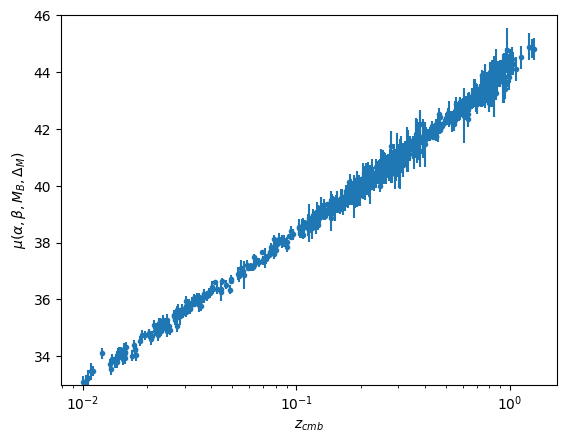

In [48]:
#plt.plot(data[0],mu_data)
plt.errorbar(data[0],mu_data,yerr=np.sqrt(np.diag(cov_data)),fmt='.')
#plt.errorbar(data[0],mu_data,fmt='.')
plt.xlabel(r'$z_{cmb}$')
plt.ylabel(r'$\mu(\alpha,\beta,M_B,\Delta_M)$')
plt.xscale('log')
plt.ylim(33,46)

In [50]:

"""def dL(Om,z):
  tmp= 
  return tmp"""
def dL(Om, z):
    integrand = lambda z_prime: 1 / np.sqrt(Om * (1 + z_prime) ** 3 + (1 - Om))
    integral, _ = integrate.quad(integrand, 0, z)
    luminosity_distance = (c / H0) * (1 + z) * integral
    return luminosity_distance

def mu_model(Omega_m,z):
  tmp= 5*np.log10(dL(z,Omega_m)/0.00001)
  return tmp

"""def ln_like(theta,data,cov):
  Om,alpha,beta,MB1,DM=theta
  muobs=mu_obs(alpha,beta,MB1,DM,data)
  z=data[0]
  mu=mu_model(Om,z)
  lnlike =np.sum()
  return lnlike"""
"""def ln_like(theta, data, cov):
    Om, alpha, beta, MB1, DM = theta
    mu_observed = mu_obs(alpha, beta, MB1, DM, data)
    z = data[0]
    mu_model = mu_model(Om, z)
    residuals = mu_observed - mu_model
    
    # Calcular la log-verosimilitud utilizando la distribución gaussiana
    log_likelihood = -0.5 * np.dot(residuals, np.linalg.solve(cov, residuals)) - 0.5 * np.log(np.linalg.det(cov))
    
    return log_likelihood"""

def ln_like(theta, data, cov):
    Om, alpha, beta, MB1, deltaM = theta
    mu_observed = mu_obs(alpha, beta, MB1, deltaM, data)
    z = data[0]
    mu_theory = mu_model(Om, z)
    cov_matrix = covmat(alpha, beta, data, cov)
    ln_likelihood = -0.5 * np.dot(mu_observed - mu_theory, np.linalg.solve(cov_matrix, mu_observed - mu_theory))
    return ln_likelihood


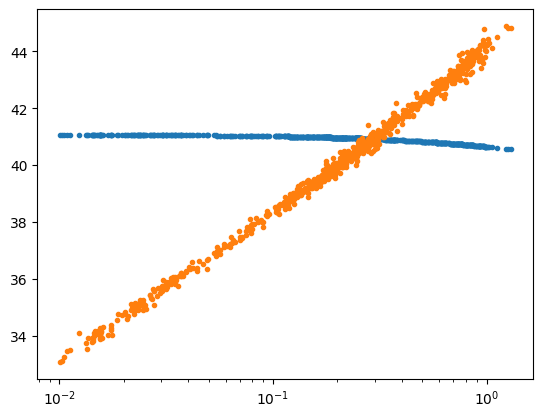

In [20]:
"""mu_theory=mu_model(Omega_m_jla,data[0])
plt.plot(data[0],mu_theory,'.')
plt.plot(data[0],mu_data,'.')

plt.xscale('log')"""

mu_theory = []
for z in data[0]:
    mu = mu_model(Omega_m_jla, z)
    mu_theory.append(mu)

plt.plot(data[0], mu_theory, '.')
plt.plot(data[0], mu_data, '.')
plt.xscale('log')


<ipython-input-55-1c61d011d522>:55: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(ln_like_diff)


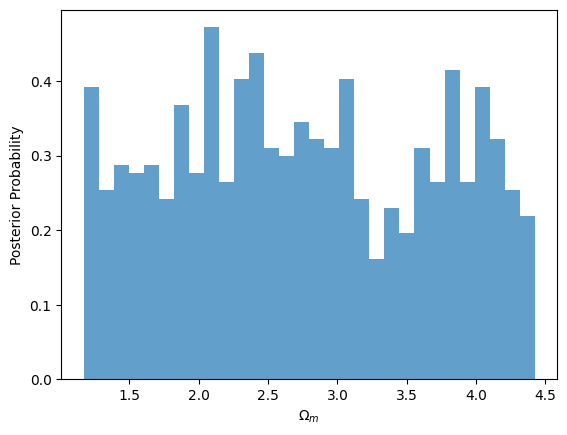

In [55]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

# Define constants
c = 299792.458 # km/s
H0 = 70.0 # km/s/Mpc

# Define function to calculate the luminosity distance
def dL(Om, z):
    integrand = lambda z_prime: 1.0 / np.sqrt(Om * (1.0 + z_prime)**3 + (1 - Om))
    integral, _ = integrate.quad(integrand, 0, z)
    return (c / H0) * (1.0 + z) * integral

# Define function to calculate the distance modulus
def mu_model(Om, z):
    dL_val = dL(Om, z)
    return 5 * np.log10(dL_val) + 25

# Define log-likelihood function
def ln_likelihood(theta, data):
    Om, = theta
    z = data[0]
    mu_obs = data[1]
    sigma = data[2]

    ln_like = 0.0
    for i in range(len(z)):
        # Calculate the model prediction for the current data point
        mu_pred = mu_model(Om, z[i])

        # Calculate the log-likelihood for the current data point
        ln_like += -0.5 * ((mu_obs[i] - mu_pred) / sigma[i])**2

    return ln_like


# Define the proposal distribution
def propose(theta, stepsize):
    return theta + np.random.normal(scale=stepsize)

# Define the Metropolis-Hastings algorithm
def metropolis_hastings(data, initial_theta, stepsize, n_samples):
    theta = initial_theta
    theta_samples = [theta]
    ln_like_current = ln_likelihood(theta, data)

    for i in range(n_samples):
        # Propose a new theta
        theta_proposed = propose(theta, stepsize)
        ln_like_proposed = ln_likelihood(theta_proposed, data)

        # Calculate the acceptance probability
        ln_like_diff = ln_like_proposed - ln_like_current
        accept_prob = np.exp(ln_like_diff)

        # Accept or reject the proposed theta
        if np.random.uniform() < accept_prob:
            theta = theta_proposed
            ln_like_current = ln_like_proposed

        # Add the current theta to the samples
        theta_samples.append(theta)

    return np.array(theta_samples)

# Load the data
data = np.loadtxt("jla_lcparams.txt", usecols=(1, 4, 5)).T

# Set the initial theta and stepsize
initial_theta = np.array([0.3])  # Initial value of Omega_m
stepsize = 0.01

# Run the MCMC algorithm
n_samples = 1000
theta_samples = metropolis_hastings(data, initial_theta, stepsize, n_samples)

# Discard burn-in samples
burn_in = int(0.2 * n_samples)
theta_samples = theta_samples[burn_in:]

# Plot the posterior distribution
plt.hist(theta_samples, bins=30, density=True, alpha=0.7)
plt.xlabel(r'$\Omega_m$')
plt.ylabel('Posterior Probability')
plt.show()


In [57]:
pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.2 MB/s eta 0:00:00


In [62]:
import emcee
import numpy as np
import scipy.integrate as integrate

# Define constants
c = 299792.458  # km/s
H0 = 70  # km/s/Mpc

# Define the model for distance luminosity
def dL(Om, z):
    integrand = lambda z: 1.0 / np.sqrt(Om * (1 + z)**3 + (1 - Om))
    result, _ = integrate.quad(integrand, 0, z)
    return (c / H0) * (1 + z) * result

# Define the model for the observed distance modulus
def mu_model(Om, z):
    return 5 * np.log10(dL(Om, z) / 10)

# Define the log-likelihood function
def ln_likelihood(theta, data):
    Om = theta
    z = data[0]
    mu_obs = data[1]
    sigma = data[2]

    ln_like = 0.0
    for i in range(len(z)):
        mu_pred = mu_model(Om, z[i])
        ln_like += -0.5 * ((mu_obs[i] - mu_pred) / sigma[i])**2

    return ln_like

# Define the log-prior function
def ln_prior(theta):
    Om = theta
    if 0.0 < Om < 1.0:
        return 0.0
    return -np.inf

# Define the log-posterior function
def ln_posterior(theta, data):
    ln_prior_val = ln_prior(theta)
    if not np.isfinite(ln_prior_val):
        return -np.inf
    return ln_prior_val + ln_likelihood(theta, data)

# Load the data
data = np.loadtxt("jla_lcparams.txt", usecols=(1, 2, 4)).T

# Set the number of walkers and dimensions
nwalkers = 10
ndim = 1

# Set the initial positions of the walkers
Om_initial = 0.3
theta_initial = Om_initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=[data])

# Run the burn-in phase
burnin_steps = 500
pos, _, _ = sampler.run_mcmc(theta_initial, burnin_steps)

# Reset the sampler and run the production phase
sampler.reset()
production_steps = 1000
sampler.run_mcmc(pos, production_steps)

# Get the samples
samples = sampler.flatchain

# Extract the posterior samples of Omega_m
Om_samples = samples[:, 0]

# Calculate the mean and standard deviation of Omega_m
Om_mean = np.mean(Om_samples)
Om_std = np.std(Om_samples)

print("Media de Omega_m:", Om_mean)
print("Desviación estándar de Omega_m:", Om_std)


Media de Omega_m: 0.8107912441599623
Desviación estándar de Omega_m: 0.1696934780220125
